$\newcommand{\defeq}{=}$
$\newcommand{\card}[1]{|#1|}$


In [1]:
%cd ..

/hdd/aouadt/these/projets/3d_segm


In [141]:
import multiprocessing as mp
from multiprocessing.pool import ThreadPool
import random

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib
from tqdm.notebook import tqdm
from IPython.display import display, Math

matplotlib.rcParams['axes.grid'] = True

import pandas as pd

In [3]:
%matplotlib widget


matplotlib.rcParams.update({"legend.fontsize": 7})
matplotlib.rcParams.update({"font.size": 7})

# Weights definition

In [4]:
from importlib import import_module
# from deep_morpho.results.results_tensorboards.Bimonn_exp_77.bimonn_last_linear.7.code.deep_morpho.models import GenericLightningModel
models_old = import_module("deep_morpho.results.results_tensorboards.Bimonn_exp_77.bimonn_last_linear.7.code.deep_morpho.models.lightning_bimonn")
LightningBiMoNNClassifierLastLinearNotBinary = models_old.LightningBiMoNNClassifierLastLinearNotBinary

weights_path = "deep_morpho/results/results_tensorboards/Bimonn_exp_77/bimonn_last_linear/7/mnistclassifchannel/bimonnclassifierlastlinearnotbinary/version_0/best_weights/epoch=26-step=21113.ckpt"
model = LightningBiMoNNClassifierLastLinearNotBinary.load_from_checkpoint(weights_path)

Ws = model.model.layers[-1].bises.weight.detach().cpu().numpy()
bs = -model.model.layers[-1].bises.bias.detach().cpu().numpy()
Ws = Ws.reshape(Ws.shape[0], np.prod(Ws.shape[1:]))


{'bise_init_method': <InitBiseEnum.CUSTOM_CONSTANT_RANDOM_BIAS: 6>, 'lui_init_method': <InitBiseEnum.CUSTOM_CONSTANT_CONSTANT_WEIGHTS_RANDOM_BIAS: 14>, 'bise_init_args': {'ub': 0.01, 'max_output_value': 0.95, 'p_for_init': 'auto'}, 'input_mean': 0.10320870578289032}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

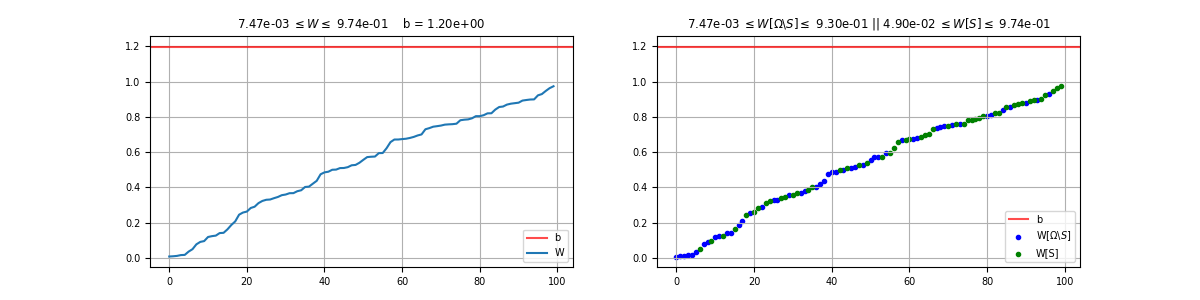

In [149]:
####### Weights initialization #######

# W = np.load("weights.npy")
# b = np.load("bias.npy")
# chout = 316
# W = Ws[chout]
# b = bs[chout]
W = np.unique(np.random.rand(100))
b = 1.2

N = len(W)
omega = np.ones_like(W).astype(bool)
epsilon = 1e-4  # for numerical stability

idx_S = len(W) // 2
thresh = W[idx_S]
# S = W >= thresh
S = np.zeros(N, dtype=bool)
S[random.sample(range(N), N // 2)] = True
S_idx = np.where(S)[0]
Sbar_idx = np.where(~S)[0]

####### Prints #######

def left_cond(Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None, epsilon: float = 1e-4):
    lb = Wini[~S].sum()
    return lb  <= bini * (1 + epsilon)  # Small relaxation for numerical errors
    
def right_cond(Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None, epsilon: float = 1e-4):
    ub = Wini[S].min()
    return ub >= bini * (1 - epsilon)  # Small relaxation for numerical errors

display(Math(r"\sum_{k \in \Omega \backslash S}w_k \leq b: " + f"{left_cond(Wini=W, bini=b, S=S)}"),)
display(Math(r"b \leq \min_{s \in S}w_s: " + f"{right_cond(Wini=W, bini=b, S=S)}"),)

fig = plt.figure(figsize=(6*2, 3))
ax = fig.add_subplot(121)
ax.axhline(y=b, c="r", label="b", alpha=.7)
ax.plot(W, label="W");
ax.set_title(fr"{W.min():.2e} $\leq W \leq$ {W.max():.2e}    b = {b:.2e}")
ax.legend();

ax = fig.add_subplot(122)
ax.axhline(y=b, c="r", label="b", alpha=.7)
# ax.plot(S_idx, W[S], label="W[S]", c="g");
# ax.plot(Sbar_idx, W[~S], label=r"W[$\Omega \backslash S$]", c="b");
ax.scatter(Sbar_idx, W[~S], label=r"W[$\Omega \backslash S$]", c="b", marker=".");
ax.scatter(S_idx, W[S], label="W[S]", c="g", marker=".");
ax.set_title(fr"{W[~S].min():.2e} $\leq W[\Omega \backslash S] \leq$ {W[~S].max():.2e} || {W[S].min():.2e} $\leq W[S] \leq$ {W[S].max():.2e}")
# ax.axvline(x=idx_S, c="g", label="threshold", alpha=.7, ls="--")
ax.legend();

plt.show();


# Matrix Computation

In [6]:
def system(Kbar, K, T):
    A = np.zeros((Kbar + K + T + 2, Kbar + K + T + 2))
    
    A[:Kbar, :Kbar] = np.eye(Kbar)
    A[:Kbar, Kbar] = 1
    
    A[Kbar:Kbar+K, Kbar] = 1
    A[Kbar:Kbar+K, Kbar+1:Kbar+1+K] = -np.eye(K)

    A[Kbar+K: Kbar+K+T, Kbar+K+1:Kbar+K+T+1] = -np.eye(T)
    A[Kbar+K: Kbar+K+T, -1] = 1

    A[-2, Kbar] = -1
    A[-2, -(T+1):] = 1

    A[-1, :Kbar] = 1
    A[-1, -1] = -1

    return A

def system_inv(Kbar, K, T):
    Ainv = np.zeros((Kbar + K + T + 2, Kbar + K + T + 2))

    c = 1 / (Kbar * (T + 1) + 1)
    a = (T + 1) * c
    d = Kbar * c


    Ainv[:Kbar, :Kbar] = np.eye(Kbar) - a
    Ainv[:Kbar, Kbar + K:-1] = c
    Ainv[:Kbar, -1] = a

    Ainv[Kbar, :Kbar] = a
    Ainv[Kbar, Kbar + K:-1] = -c
    Ainv[Kbar, -1] = -a

    Ainv[Kbar+1:Kbar+K+1, :Kbar] = a
    Ainv[Kbar+1:Kbar+K+1, Kbar: Kbar + K] = -np.eye(K)
    Ainv[Kbar+1:Kbar+K+1, Kbar + K:-1] = -c
    Ainv[Kbar+1:Kbar+K+1, -1] = -a

    Ainv[Kbar+K+1:-1, :Kbar] = c
    Ainv[Kbar+K+1:-1, Kbar + K:-2] = d - np.eye(T)
    Ainv[Kbar+K+1:-1, -2] = d
    Ainv[Kbar+K+1:-1, -1] = -c

    Ainv[-1, :Kbar] = c
    Ainv[-1, Kbar + K:-1] = d
    Ainv[-1, -1] = -c

    return Ainv

In [4]:
Kbar, K, T = 13, 4, 10
A = system(Kbar, K, T)
# display(A)
Ainv = np.linalg.inv(A)
Ainv2 = system_inv(Kbar, K, T)
# print(np.array_str((Ainv), precision=2, suppress_small=True))
# print(np.array_str((Ainv2), precision=2, suppress_small=True))
print(np.allclose(Ainv, Ainv2))
print(np.allclose(Ainv @ A, np.eye(A.shape[0])))


True
True


In [5]:
a = Ainv[0, -1]
c = Ainv[-1, 0]
d = Ainv[-1, -2]

X = np.array([a, c, d])

#
u = np.array([
  #  a     c    d
    [Kbar, 1,   0],
    [0, Kbar,  -1],
    [0,    1, T+1]
])

u @ X

array([1.00000000e+00, 1.38777878e-17, 1.00000000e+00])

In [6]:
print("c")
print(c)
print(1 / (Kbar*(T+1) + 1))

print("d")
print(d)
print(Kbar / (Kbar*(T+1) + 1))

print("a")
print(a)
print((T+1) / (Kbar*(T+1) + 1))

c
0.006944444444444445
0.006944444444444444
d
0.09027777777777778
0.09027777777777778
a
0.0763888888888889
0.0763888888888889


# Iterative

## Method

In [7]:
from dataclasses import dataclass

@dataclass
class IterativeProjection:
    Wini: np.ndarray
    bini: float
    S: np.ndarray

    @property
    def N(self):
        return len(self.Wini)

    def solve(self):
        # self.Wvar = cp.Variable(self.N)
        self.Wvar = cp.Variable(self.Wini.shape)
        self.bvar = cp.Variable(1)

        self.constraint0 = [cp.sum(self.Wvar[~self.S]) <= self.bvar]
        # self.constraintsT = [self.bvar <= self.Wvar[i] for i in np.where(self.S)[0]]
        # self.constraintsK = [self.Wvar[i] >= 0 for i in range(N)]
        self.constraintsT = [self.bvar <= self.Wvar[self.S]]
        self.constraintsK = [self.Wvar >= 0]

        self.constraints = self.constraint0 + self.constraintsT + self.constraintsK

        self.objective = cp.Minimize(1/2 * cp.sum_squares(self.Wvar - self.Wini) + 1/2 * cp.sum_squares(self.bvar - self.bini))
        self.prob = cp.Problem(self.objective, self.constraints)
        self.prob.solve()

        return self

    @property
    def W(self):
        return self.Wvar.value
    
    @property
    def b(self):
        return self.bvar.value

    @property
    def K(self):
        return np.isclose(self.W, 0) & ~self.S

    @property
    def Kbar(self):
        return ~self.S & ~self.K
    
    @property
    def T(self):
        return self.W == self.b

    @property
    def lambda0(self):
        return self.constraint0[0].dual_value
    
    @property
    def lambdat(self):
        return np.array([constraint.dual_value for constraint in self.constraintsT])
    
    @property
    def lambdak(self):
        return np.array([constraint.dual_value for constraint in self.constraintsK])

    @property
    def loss(self):
        return self.prob.value
    
    def __repr__(self):
        return (
            f"{self.__class__.__name__}("
            f"Loss={self.loss:.4e} "
            f"Kbar: {self.Kbar.sum()} K: {self.K.sum()} T: {self.T.sum()}"
            ")"
        )


## Duration

In [24]:
Ns = range(10, 1000, 50)
all_times = np.zeros(len(Ns))
all_stds = np.zeros(len(Ns))
for N_idx, N in tqdm(enumerate(Ns)):
    W2 = np.random.rand(N)
    S2 = W2 > .5
    tim = %timeit -q -o IterativeProjection(Wini=W2, bini=b, S=S2).solve()
    all_times[N_idx] = tim.average
    all_stds[N_idx] = tim.stdev


0it [00:00, ?it/s]

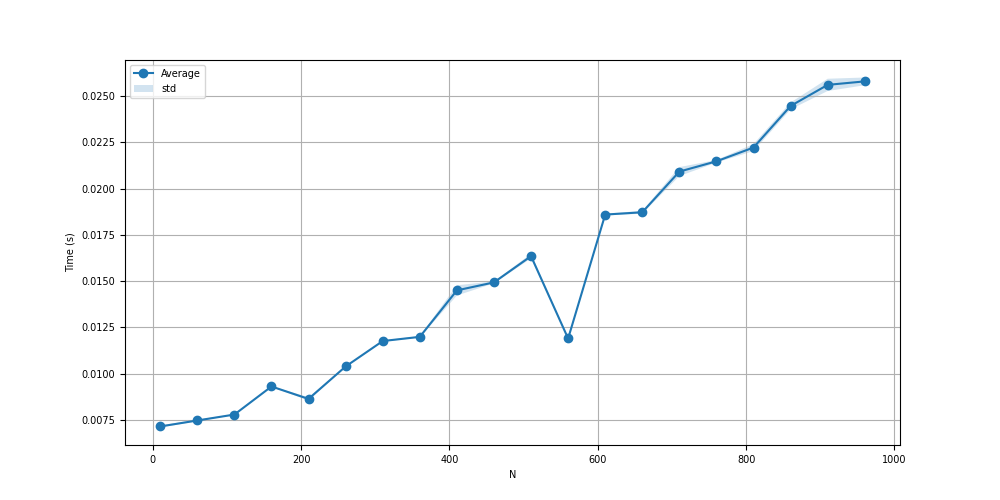

In [25]:
fig = plt.figure(figsize=(10, 5))
# Plot average and uncertainty
plt.plot(Ns, all_times, '-o', label="Average")
plt.fill_between(Ns, all_times - all_stds, all_times + all_stds, alpha=.2, label="std")
plt.xlabel("N")
plt.ylabel("Time (s)")
plt.legend()

## Analysis

In [29]:
# W = np.random.rand(100)
# chout = np.random.randint(Ws.shape[0])
chout = 378
print(chout)
W = Ws[chout]
b = bs[chout]
W_unique = np.unique(W)

all_projs = []
for idx in tqdm(range(len(W_unique))):
    w_value = W_unique[idx]
    all_projs.append(IterativeProjection(Wini=W, bini=b, S=W >= w_value).solve())
    # all_times[N_idx] = tim.average
    # all_stds[N_idx] = tim.stdev

losses = np.array([proj.loss for proj in all_projs])
diff = losses[1:] - losses[:-1]
min_idx = losses.argmin()
print((diff[:min_idx] < 0).all(), (diff[min_idx:] > 0).all())
print(all_projs[min_idx])


378


  0%|          | 0/784 [00:00<?, ?it/s]

True True
IterativeProjection(Loss=0.0000e+00 Kbar: 780 K: 0 T: 0)


In [26]:


# W = np.random.rand(100)
# chout = np.random.randint(Ws.shape[0])
chout = 378
print(chout)
W = Ws[chout]
b = bs[chout]
W_unique = np.unique(W)

pool = ThreadPool(mp.cpu_count())

# all_projs = pool.starmap(lambda w, b, val: IterativeProjection(Wini=w, bini=b, S=w >= val).solve(), [(W, b, w_value) for w_value in W_unique])

# all_projs = []
# for idx in tqdm(range(len(W_unique))):
#     w_value = W_unique[idx]
#     all_projs.append(IterativeProjection(Wini=W, bini=b, S=W >= w_value).solve())
#     # all_times[N_idx] = tim.average
#     # all_stds[N_idx] = tim.stdev

# losses = np.array([proj.loss for proj in all_projs])
# diff = losses[1:] - losses[:-1]
# min_idx = losses.argmin()
# print((diff[:min_idx] < 0).all(), (diff[min_idx:] > 0).all())
# print(all_projs[min_idx])


378


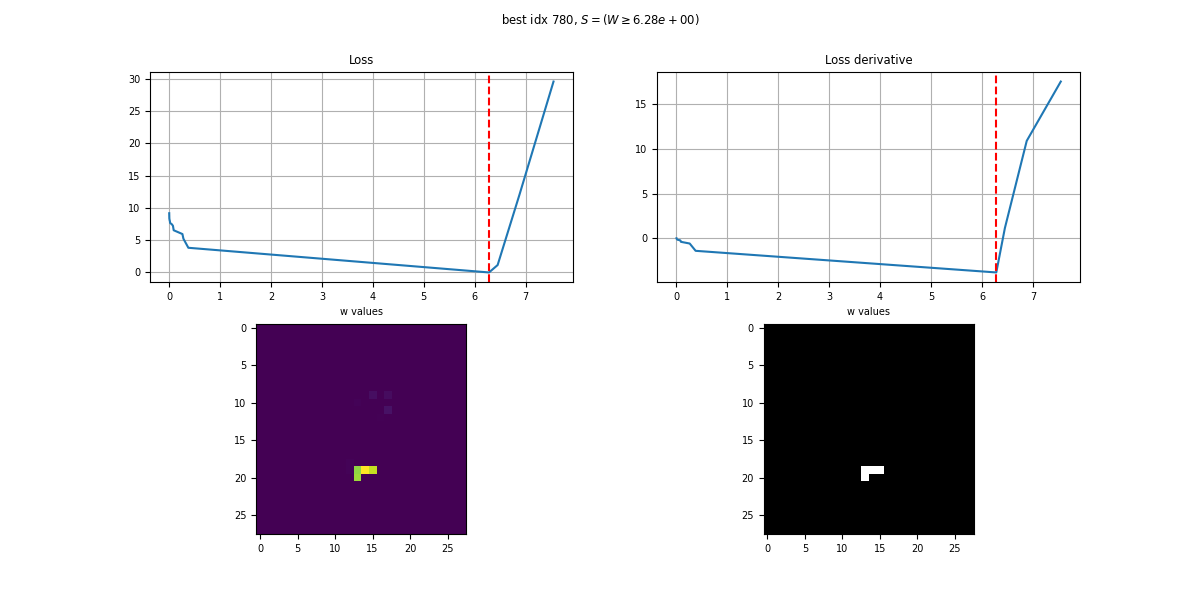

In [30]:
plt.figure(figsize=(12, 6))

plt.suptitle(rf"best idx {min_idx}, $S = (W \geq {W_unique[min_idx]:.2e})$")

plt.subplot(221)
plt.plot(W_unique, losses,)
plt.axvline(W_unique[min_idx], color='r', linestyle='--')
plt.title("Loss")
plt.xlabel("w values")

plt.subplot(222)
plt.plot(W_unique[1:], diff,)
plt.axvline(W_unique[min_idx], color='r', linestyle='--')
plt.title("Loss derivative")
plt.xlabel("w values")

plt.subplot(223)
plt.imshow(W.reshape(28, 28), )
plt.grid(False)
# plt.title("W")

plt.subplot(224)
plt.imshow(W.reshape(28, 28) >= W_unique[min_idx], interpolation='nearest', cmap='gray')
plt.grid(False)
# plt.title("S")


## Tests

In [152]:
prob1 = IterativeProjection(Wini=W, bini=b, S=S).solve()

print(f"Loss: {prob1.loss:.4f}, Kbar: {prob1.Kbar.sum()}, K: {prob1.K.sum()}, T: {prob1.T.sum()}")

prob1.X = np.concatenate([prob1.W[prob1.Kbar], prob1.lambda0,  prob1.lambdak[prob1.lambdak != 0], prob1.lambdat[prob1.lambdat != 0].reshape(-1), prob1.b])
prob1.Y = np.concatenate([W[prob1.Kbar], W[prob1.K], W[prob1.T], np.array([b, 0]),])
prob1.A = system(prob1.Kbar.sum(), prob1.K.sum(), prob1.T.sum())
prob1.Ainv = system_inv(prob1.Kbar.sum(), prob1.K.sum(), prob1.T.sum())


print((prob1.A@prob1.X - prob1.Y).sum())
print((prob1.Ainv@prob1.Y - prob1.X).sum())

Loss: 7.1483, Kbar: 6, K: 44, T: 13
-2.275957200481571e-15
-7.337880303381894e-16


In [9]:
print("lower bound K", (prob1.T.sum() * W.min() + b) / ((prob1.T.sum() + 1) * prob1.Kbar.sum() * W.max()))
print("lower bound T", (b - prob1.Kbar.sum() * W.max() ) / (prob1.Kbar.sum() * W.max() - W.min()))

lower bound K 0.006633222716111693
lower bound T -0.890791356527216


In [10]:
W_2 = W + 0
W_2[prob1.K] = W_2[prob1.K][-1]

prob_2 = IterativeProjection(Wini=W_2, bini=b, S=S).solve()
print(f"Loss: {prob_2.loss:.4f}, Kbar: {prob_2.Kbar.sum()}, K: {prob_2.K.sum()}, T: {prob_2.T.sum()}")

prob_2.X = np.concatenate([prob_2.W[prob_2.Kbar], prob_2.lambda0,  prob_2.lambdak[prob_2.lambdak != 0], prob_2.lambdat[prob_2.lambdat != 0].reshape(-1), prob_2.b])
prob_2.Y = np.concatenate([W_2[prob_2.Kbar], W_2[prob_2.K], W_2[prob_2.T], np.array([b, 0]),])
prob_2.A = system(prob_2.Kbar.sum(), prob_2.K.sum(), prob_2.T.sum())
prob_2.Ainv = system_inv(prob_2.Kbar.sum(), prob_2.K.sum(), prob_2.T.sum())


print((prob_2.A@prob_2.X - prob_2.Y).sum())
print((prob_2.Ainv@prob_2.Y - prob_2.X).sum())

Loss: 4.2248, Kbar: 11, K: 39, T: 19
-3.3306690738754696e-16
3.561387296180385e-15


In [11]:
print("W1 = W2", np.isclose(prob1.W, prob_2.W).all())
print("b1 = b2", np.isclose(prob1.b, prob_2.b).all())

W1 = W2 True
b1 = b2 True


In [12]:
W_3 = W + 0
W_3[prob1.K] = 0

prob_3 = IterativeProjection(Wini=W_3, bini=b, S=S).solve()
print(f"Loss: {prob_3.loss:.4f}, Kbar: {prob_3.Kbar.sum()}, K: {prob_3.K.sum()}, T: {prob_3.T.sum()}")

prob_3.X = np.concatenate([prob_3.W[prob_3.Kbar], prob_3.lambda0,  prob_3.lambdak[prob_3.lambdak != 0], prob_3.lambdat[prob_3.lambdat != 0].reshape(-1), prob_3.b])
prob_3.Y = np.concatenate([W_3[prob_3.Kbar], W_3[prob_3.K], W_3[prob_3.T], np.array([b, 0]),])
prob_3.A = system(prob_3.Kbar.sum(), prob_3.K.sum(), prob_3.T.sum())
prob_3.Ainv = system_inv(prob_3.Kbar.sum(), prob_3.K.sum(), prob_3.T.sum())


print((prob_3.A@prob_3.X - prob_3.Y).sum())
print((prob_3.Ainv@prob_3.Y - prob_3.X).sum())

Loss: 1.1180, Kbar: 11, K: 39, T: 19
5.329070518200751e-15
2.529877349277676e-15


In [13]:
print("W1 = W3", np.isclose(prob1.W, prob_3.W).all())
print("b1 = b3", np.isclose(prob1.b, prob_3.b).all())

W1 = W3 True
b1 = b3 True


## Check Threshold

In [55]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    # return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))

In [128]:
N = 9
Wini = np.random.rand(N)
bini = .5

all_probs = []

for set_ in tqdm(powerset(range(N))):
    S = np.zeros(N, dtype=bool)
    S[list(set_)] = True
    all_probs.append(IterativeProjection(Wini=Wini, bini=bini, S=S).solve())



0it [00:00, ?it/s]

In [129]:
best_S = all_probs[np.argmin([prob.loss for prob in all_probs])].S
print(Wini)
print(best_S)
print(Wini[best_S].min() > Wini[~best_S].max())

# plt.figure()
# plt.plot([prob.loss for prob in all_probs])

[0.08523624 0.69398146 0.49881991 0.05941102 0.89829777 0.46309851
 0.46316364 0.73035237 0.4006477 ]
[False  True  True False  True  True  True  True False]
True


# Projection

In [38]:
class AnalyticalProjection:
    
    def __init__(
        self, 
        Wini: np.ndarray = None, 
        bini: np.ndarray = None, 
        S: np.ndarray = None, 
        T: np.ndarray= None, 
        K: np.ndarray= None, 
        epsilon: float = 1e-4
    ):
        self.Wini = Wini
        self.bini = bini
        self.S = S
        self.T = T
        self.K = K
        self.epsilon = epsilon

        self.b = None
        self.lambda0: float = None
        self.lambdat: np.ndarray = None
        self.lambdak: np.ndarray = None
        self.W = None
        self.loss = None
        self.summary = None

    @staticmethod
    def left_cond(Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None, epsilon: float = 1e-4):
        lb = Wini[~S].sum()
        return lb  <= bini * (1 + epsilon)  # Small relaxation for numerical errors
        
    @staticmethod
    def right_cond(Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None, epsilon: float = 1e-4):
        ub = Wini[S].min()
        return ub >= bini * (1 - epsilon)  # Small relaxation for numerical errors

    @staticmethod
    def left_margin(Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None):
        lb = Wini[~S].sum()
        return bini - lb

    @staticmethod
    def right_margin(Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None):
        ub = Wini[S].min()
        return ub - bini

    @staticmethod
    def positive_margin(Wini: np.ndarray = None):
        return Wini.min()

    @staticmethod
    def positive_cond(Wini: np.ndarray = None, epsilon: float = 1e-4):
        return Wini.min() >= -epsilon

    def lagrangian_cond(self,):
        if self.lambdat is not None and (self.lambdat[self.T] < -self.epsilon).any():
            return False
        
        if self.lambda0 is not None and self.lambda0 < -self.epsilon:
            return False
        
        if self.lambdak is not None and (self.lambdak[self.K] < -self.epsilon).any():
            return False

        return True


    def get_summary(self, Wini, bini, S, T=None, K=None):
        return {
            "b": self.b,
            "lambda0": self.lambda0,
            "loss": self.loss,
            "lambdat": self.lambdat[T] if self.lambdat is not None else None,
            "lambdak": self.lambdak[K] if self.lambdak is not None else None,
            "W": self.W,
            "conds_init_left": self.left_cond(Wini=Wini, bini=bini, S=S),
            "conds_init_right": self.right_cond(Wini=Wini, bini=bini, S=S),
            "conds_init_positive": self.positive_cond(Wini=Wini),
            "margins_init_left": self.left_margin(Wini=Wini, bini=bini, S=S),
            "margins_init_right": self.right_margin(Wini=Wini, bini=bini, S=S),
            "margins_init_positive": self.positive_margin(Wini=Wini),
            "conds_proj_left": self.left_cond(Wini=self.W, bini=self.b, S=S),
            "conds_proj_right": self.right_cond(Wini=self.W, bini=self.b, S=S),
            "conds_proj_positive": self.positive_cond(Wini=self.W),
            "margins_proj_left": self.left_margin(Wini=self.W, bini=self.b, S=S),
            "margins_proj_right": self.right_margin(Wini=self.W, bini=self.b, S=S),
            "margins_proj_positive": self.positive_margin(Wini=self.W),
            "lagrangian_cond": self.lagrangian_cond(),
        }

    def projection_left_right(self,):
        Wini, bini, T, K, S = self.Wini, self.bini, self.T, self.K, self.S
        omega = np.ones_like(Wini).astype(bool)

        card_sbar = (~S).sum()
        card_T = T.sum()
        card_K = K.sum()
        card_Kbar = card_sbar - card_K
        wsum_T = Wini[T].sum()
        wsum_Kbar = Wini[~S & ~K].sum()

        denom = np.float32(1 / (card_Kbar * (card_T  + 1) + 1))

        self.b = denom * (wsum_Kbar + card_Kbar * (wsum_T + bini))

        self.lambdat = np.zeros_like(Wini)
        self.lambdat[T] = self.b - Wini[T]

        self.lambda0 = denom * ((card_T + 1) * wsum_Kbar - wsum_T - bini)
        
        self.lambdak = np.zeros_like(Wini)
        self.lambdak[K] = self.lambda0 - Wini[K]

        W = np.zeros_like(Wini)
        W[T] = self.b
        W[S & ~T] = Wini[S & ~T]
        W[~K & ~S] = Wini[~K & ~S] - self.lambda0
        self.W = W

        # self.loss = ((Wini[T] - self.b)**2).sum() + card_sbar * self.lambda0 ** 2 + (self.b - bini) ** 2
        self.loss = 1/2 * (((self.W - Wini) ** 2).sum() + (self.b - bini) ** 2)

        self.summary = self.get_summary(Wini=Wini, bini=bini, S=S, T=T)

        return self



In [10]:
class MultiPlot:

    def __init__(self, nrow, ncol, *args, **kwargs):
        self.nrow = nrow
        self.ncol = ncol
        self.fig = plt.figure(*args, **kwargs)
    
    def add_subplot(self, pos, nrow=None, ncol=None, *args, **kwargs):
        if nrow is None:
            nrow = self.nrow
        if ncol is None:
            ncol = self.ncol
        if isinstance(pos, tuple):
            pos = (pos[0] - 1) * self.ncol + pos[1]
        return self.fig.add_subplot(nrow, ncol, pos, *args, **kwargs)

In [153]:
# Left Right Projection

# all_Ts = np.arange(idx_S+1, len(W))
all_Ts = np.where(S)[0][1:]
all_Ks = np.where(~S)[0]
# all_Ks = np.arange(idx_S)
all_res = []
for idx_T in tqdm(all_Ts):
    T = S & (W <= W[idx_T])
    for idx_K in all_Ks:
        K = ~S & (W <= W[idx_K])

        proj = AnalyticalProjection(Wini=W, bini=b, S=S, T=T, K=K, epsilon=epsilon).projection_left_right()
        res = proj.summary
        res["idx_T"] = idx_T
        res["T"] = T
        res["idx_K"] = idx_K
        res["K"] = K
        res["proj"] = proj
        all_res.append(res)

df = pd.DataFrame(all_res, )
# df.index = df["idx_T"]
df["lambdat_neg"] = df["lambdat"].apply(lambda x: (x < -epsilon).sum())
df["lambdak_neg"] = df["lambdak"].apply(lambda x: (x < -epsilon).sum())
df["lambdat_min"] = df["lambdat"].apply(lambda x: x.min())
df["lambdak_min"] = df["lambdak"].apply(lambda x: x.min())
# # df["Ws_min"] = df["W"].apply(lambda x: x[S].min())


# good_idx = np.where(
#     # (df.lambda0.values > 0) & (df["lambdat_neg"] == 0) & (df["Ws_min"] - df["b"] >= 0)
#     df["right_cond_proj"] & df["left_cond_proj"] & df["lagrangian_cond"]
# )[0]
# print("Possibles Ts:", len(good_idx))
# if len(good_idx) == 0:
#     best_idx = None
#     print("No solution found")
# else:
#     best_idx = df["loss"].iloc[good_idx].idxmin()
#     print("Constraint left", df.loc[best_idx, "left_cond_proj"], "Margin left", df.loc[best_idx, "left_margin_proj"])
#     print("constraint right", df.loc[best_idx, "right_cond_proj"], "Margin right", df.loc[best_idx, "right_margin_proj"])
#     print("Wproj min", df.loc[best_idx, "W"].min(),)
# print("Best idx", best_idx)



  0%|          | 0/49 [00:00<?, ?it/s]

In [154]:
ok_df = df.loc[(df[["conds_proj_left", "conds_proj_right", "conds_proj_positive"]].sum(1) == 3)]
row = ok_df.iloc[ok_df["loss"].argmin()]

card_K = row["K"].sum()
card_T = row["T"].sum()
card_Kbar = S.sum() - card_K

# A = system(prob1.Kbar.sum(), prob1.K.sum(), prob1.T.sum())
# Ainv = system_inv(prob1.Kbar.sum(), prob1.K.sum(), prob1.T.sum())

A = system(card_Kbar, card_K, card_T)
Ainv = system_inv(card_Kbar, card_K, card_T)


Wproj, lambda0, lambdak, lambdat, bproj = row["W"], row["lambda0"], row["lambdak"], row["lambdat"], row["b"]

X = np.concatenate([Wproj[prob1.Kbar], np.array([lambda0]),  lambdak[lambdak != 0], lambdat[lambdat != 0], np.array([bproj])])
Y = np.concatenate([W[prob1.Kbar], W[prob1.K], W[prob1.T], np.array([b, 0]),])

print(np.isclose(A @ X - Y, np.zeros_like(Y)))
print("W", np.isclose(row["W"], prob1.W).all())
print("b", np.isclose(row["b"], prob1.b).all())
print("loss", np.isclose(row["loss"], prob1.loss).all())

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False]
W True
b True
loss True


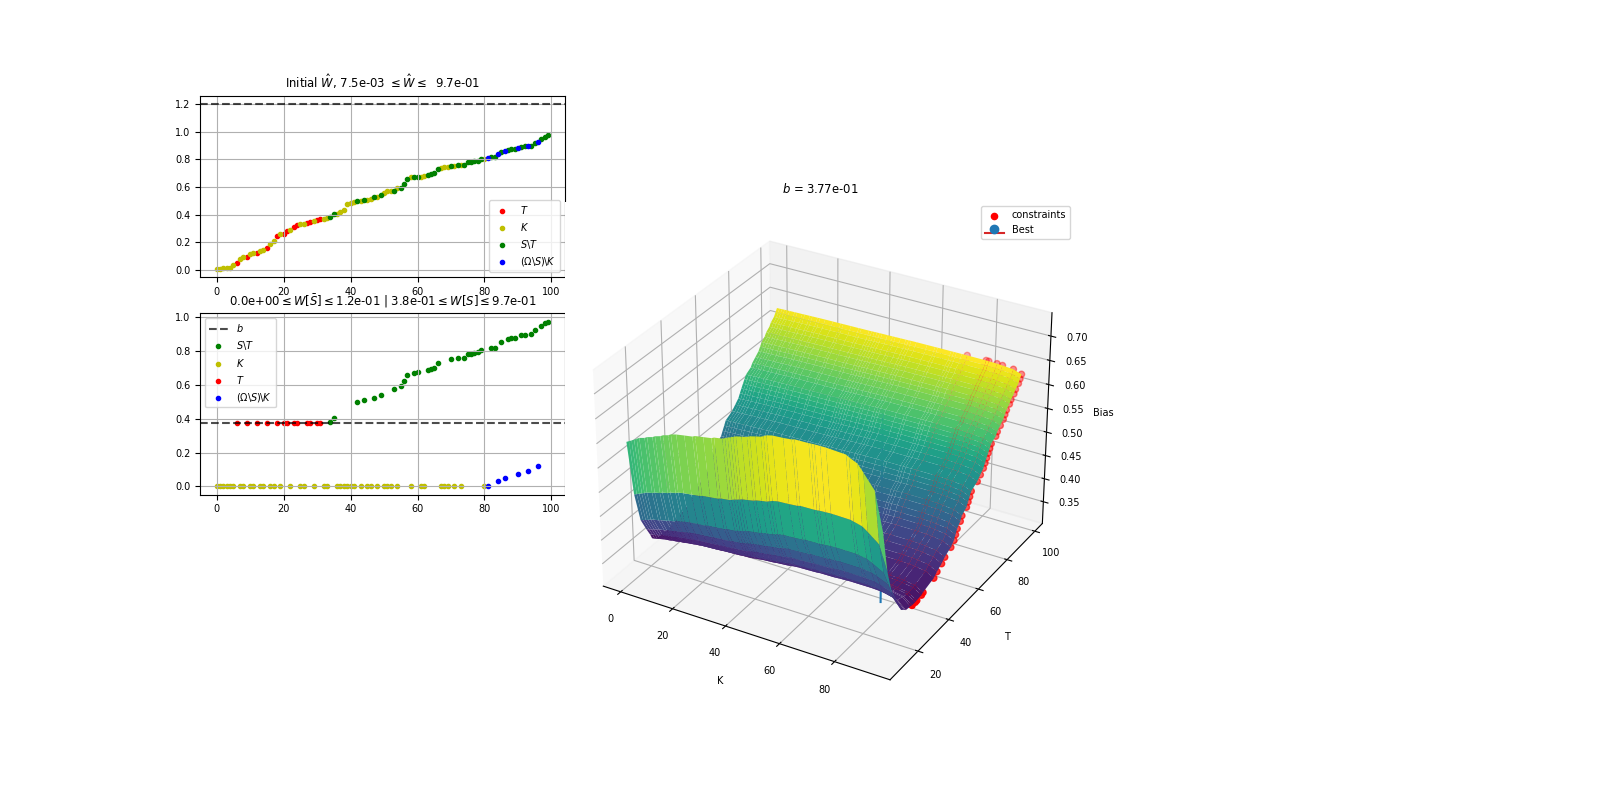

In [167]:
cur_Ks = all_Ks[:-1]
cur_Ts = all_Ts
cur_df = ok_df[ok_df["idx_K"] < all_Ks[-1]]


mplot = MultiPlot(3, 3, figsize=(4*4, 4*2))

# Init W ######################################

ax = mplot.add_subplot((1, 1))
ax.axhline(y=b, color="black", alpha=.7, ls="--")
# ax.plot(Sbar_idx, W[~S], c="b", label=r"$\Omega \backslash S$")

best_T = row["T"]
best_K = row["K"]
T_idx = np.where(best_T)[0]
K_idx = np.where(best_K)[0]

ax.scatter(T_idx, W[best_T], c="r", label=r"$T$", marker=".")
# ax.axvline(x=T_idx[0], c="r", alpha=.7, ls="--")

ax.scatter(K_idx, W[best_K], c="y", label=r"$K$", marker=".")
# ax.axvline(x=K_idx[-1], c="y", alpha=.7, ls="--")

Tbar_idx = np.where(S & ~best_T)[0]
ax.scatter(Tbar_idx, W[~best_T & S], c="g", label=r"$S \backslash T$", marker=".")
# ax.axvline(x=Tbar_idx[0], c="g", alpha=.7, ls="--")

Kbar_idx = np.where(~S & ~best_K)[0]
ax.scatter(Kbar_idx, W[~best_K & ~S], c="b", label=r"$(\Omega \backslash S) \backslash K$", marker=".")
# ax.axvline(x=Kbar_idx[-1], c="g", alpha=.7, ls="--")


ax.set_title(rf"Initial $\hat W$, {W.min():.1e} $\leq \hat W \leq $  {W.max():.1e}")
ax.legend()

Wbest = row["W"]
bbest = row["b"]

# Proj W ######################################

ax = mplot.add_subplot((2, 1))
ax.set_title(fr"{Wbest[~S].min():.1e}$\leq W[\bar S] \leq ${Wbest[~S].max():.1e} | {Wbest[S].min():.1e}$\leq W[S] \leq ${Wbest[S].max():.1e}")

ax.axhline(bbest, c="k", alpha=.7, ls="--", label=r"$b$")
# ax.plot(Tbar_idx, Wbest[~best_T & S], c="g", label=r"$S \backslash T$")
ax.scatter(Tbar_idx, Wbest[~best_T & S], c="g", label=r"$S \backslash T$", marker=".")
# ax.plot(Tbar_idx, W[~best_T & S], c="g", alpha=.6, ls="--")
# ax.scatter(Tbar_idx, W[~best_T & S], c="g", alpha=.6, ls="--", marker="+")

# ax.plot(K_idx, W[best_K], c="y", alpha=.6, ls="--")
# ax.scatter(K_idx, W[best_K], c="y", alpha=.6, ls="--", marker="+")
# ax.plot(K_idx, Wbest[best_K], c="y", label=r"$K$")
ax.scatter(K_idx, Wbest[best_K], c="y", label=r"$K$", marker=".")

# ax.plot(T_idx, Wbest[best_T], c="r", label=r"$T$")
ax.scatter(T_idx, Wbest[best_T], c="r", label=r"$T$", marker=".")
# ax.plot(T_idx, W[best_T], c="r", alpha=.6, ls="--")
# ax.scatter(T_idx, W[best_T], c="r", alpha=.6, ls="--", marker="+")

# ax.plot(Kbar_idx, W[~best_K & ~S], c="b", alpha=.6, ls="--")
# ax.scatter(Kbar_idx, W[~best_K & ~S], c="b", alpha=.6, ls="--", marker="+")
# ax.plot(Kbar_idx, Wbest[~best_K & ~S], c="b", label=r"$(\Omega \backslash S) \backslash K$")
ax.scatter(Kbar_idx, Wbest[~best_K & ~S], c="b", label=r"$(\Omega \backslash S) \backslash K$", marker=".")

# ax.plot(Sbar_idx, Wbest[~S], c="b", label=r"$\Omega \backslash S$")
# ax.plot(Sbar_idx, W[~S], c="b", alpha=.6, ls="--")
ax.legend()

# Bias wrt T, K ######################################
ax = mplot.fig.add_subplot(6, 2, (3, 12), projection="3d")
# ax = mplot.fig.add_subplot(2,1,2, projection="3d")
bias_table = pd.pivot_table(df, index="idx_T", columns="idx_K", values="b")

ax.scatter3D(cur_df["idx_K"].values, cur_df["idx_T"].values, cur_df["b"].values, color="red", label="constraints")
ax.plot_surface(*np.meshgrid(all_Ks[:-1], all_Ts), bias_table.values[:, :-1], cmap="viridis")
ax.set_xlabel("K")
ax.set_ylabel("T")
ax.set_zlabel("Bias")
ax.set_title(rf"$b$ = {row['b']:.2e}")
ax.stem([row["idx_K"]], [row["idx_T"]], [row["b"]], bottom=ax.get_zlim()[1], label="Best")
ax.stem([row["idx_K"]], [row["idx_T"]], [row["b"]], bottom=ax.get_zlim()[0], )
ax.legend()

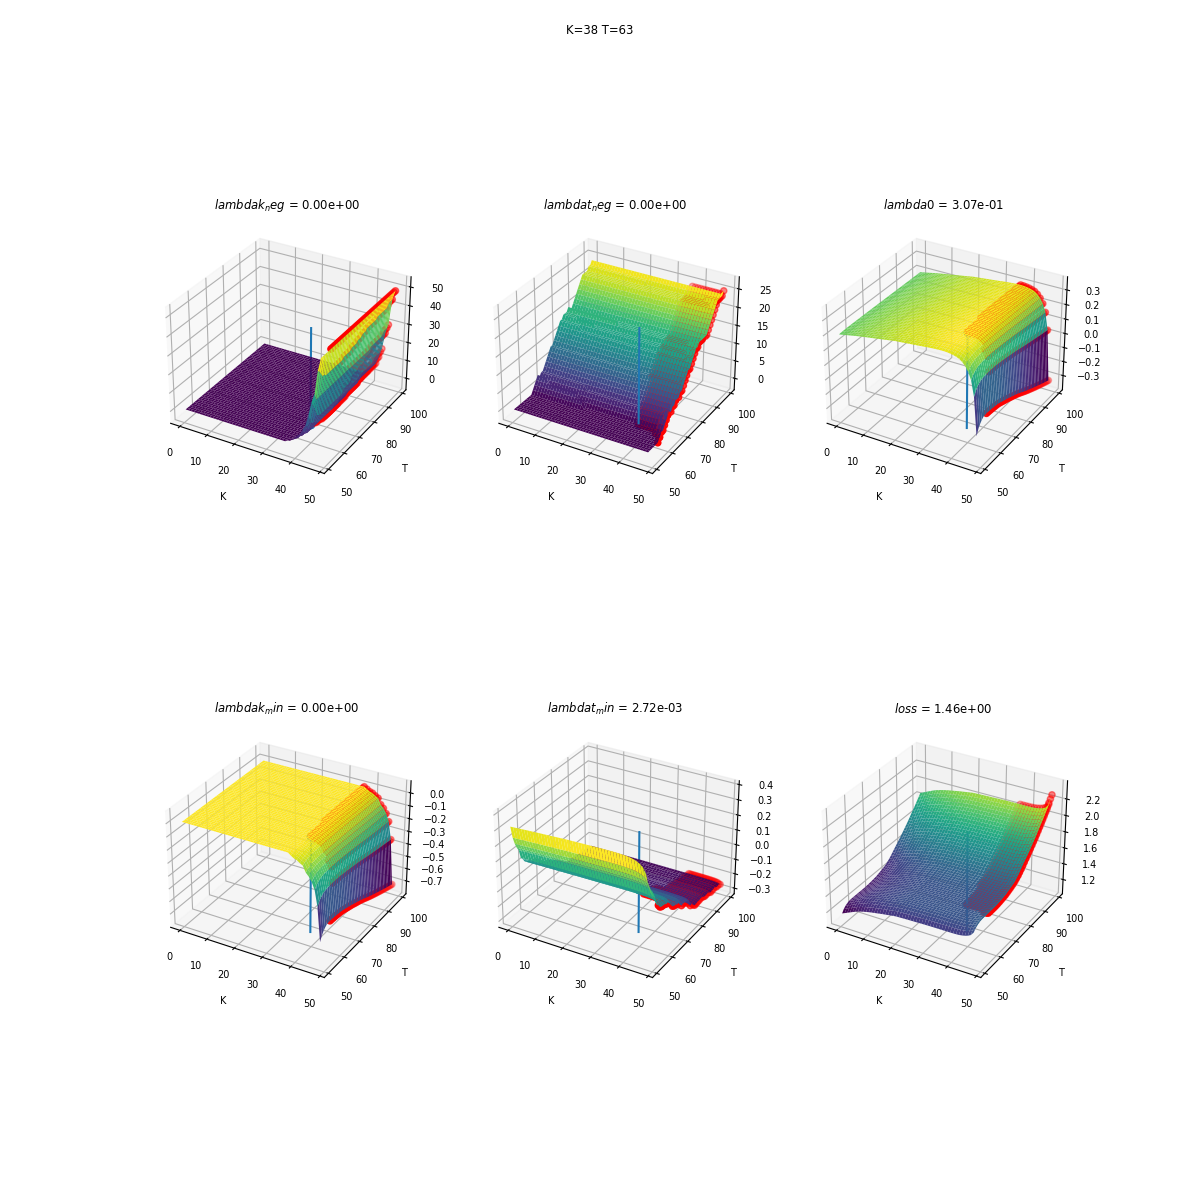

In [22]:
cur_Ks = all_Ks[:-1]
cur_Ts = all_Ts
cur_df = ok_df[ok_df["idx_K"] < all_Ks[-1]]


def plot_3d(ax, col):
    col_table = pd.pivot_table(df, index="idx_T", columns="idx_K", values=col)
    ax.scatter3D(cur_df["idx_K"].values, cur_df["idx_T"].values, cur_df[col].values, color="red", label="constraints")
    ax.plot_surface(*np.meshgrid(all_Ks[:-1], all_Ts), col_table.values[:, :-1], cmap="viridis")
    ax.set_xlabel("K")
    ax.set_ylabel("T")
    # ax.set_zlabel(col)
    ax.set_title(rf"${col}$ = {row[col]:.2e}")
    ax.stem([row["idx_K"]], [row["idx_T"]], [row[col]], bottom=ax.get_zlim()[1], label="Best")
    ax.stem([row["idx_K"]], [row["idx_T"]], [row[col]], bottom=ax.get_zlim()[0], )

mplot = MultiPlot(2, 3, figsize=(4*3, 4*3))
mplot.fig.suptitle(f"K={row['idx_K']} T={row['idx_T']}")

# Loss wrt T ######################################
ax = mplot.add_subplot((2, 3), projection="3d")
plot_3d(ax, "loss")

# Number of negative lagrangians lambda_k wrt T ######################################
ax = mplot.add_subplot((1, 1), projection="3d")
plot_3d(ax, "lambdak_neg")

# Number of negative lagrangians lambda_t wrt T ######################################
ax = mplot.add_subplot((1, 2), projection="3d")
plot_3d(ax, "lambdat_neg")


# Lambda 0 wrt T ######################################
ax = mplot.add_subplot((1, 3), projection="3d")
plot_3d(ax, "lambda0")

# Min lambda_k wrt T ######################################
ax = mplot.add_subplot((2, 1), projection="3d")
plot_3d(ax, "lambdak_min")

# Min lambda_t wrt T ######################################
ax = mplot.add_subplot((2, 2), projection="3d")
plot_3d(ax, "lambdat_min")

# # Constraint right margin wrt T ######################################
# ax = mplot.add_subplot((2, 2), projection="3d")
# plot_3d(ax, "margins_proj_right")

# # Constraint left margin wrt T ######################################
# ax = mplot.add_subplot((2, 3), projection="3d")
# plot_3d(ax, "margins_proj_left",)





In [ ]:
all_Ts = np.arange(idx_S+1, len(W))
all_res = []
for idx, idx_T in enumerate(all_Ts):
    T = S & (W <= W[idx_T])
    proj = Projection(Wini=W, bini=b, S=S, T=T).projection_right()
    res = proj.summary
    res["idx_T"] = idx_T
    res["T"] = T
    res["proj"] = proj
    all_res.append(res)

df2 = pd.DataFrame(all_res, )
df2.index = df2["idx_T"]
df2["lambdat_neg"] = df2["lambdat"].apply(lambda x: (x < 1e-5).sum())
df2["Ws_min"] = df2["W"].apply(lambda x: x[S].min())

good_idx = np.where(
    df2["right_cond_proj"] & df2["lagrangian_cond"]
)[0]
print("Possibles Ts:", len(good_idx))
if len(good_idx) == 0:
    best_idx = None
    print("No solution found")
else:
    # best_idx = df2.index[good_idx[0][0]]
    best_idx = df2["loss"].iloc[good_idx].idxmin()

    print("Constraint left", df2.loc[best_idx, "left_cond_proj"], "Margin left", df2.loc[best_idx, "left_margin_proj"])
    print("constraint right", df2.loc[best_idx, "right_cond_proj"], "Margin right", df2.loc[best_idx, "right_margin_proj"])
print("Best idx", best_idx)




Possibles Ts: 1
Constraint left False Margin left -57.23062304967187
constraint right True Margin right 0.0
Best idx 274


In [11]:
df2.loc[df2["right_cond_proj"] & df2["left_cond_proj"], ["loss"]]

NameError: name 'df2' is not defined

NameError: name 'df2' is not defined

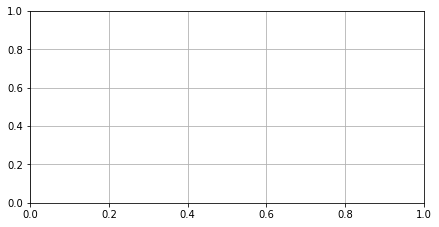

In [12]:


# mplot = plt.figure(figsize=(6*4, 6*2))
mplot = MultiPlot(3, 3, figsize=(6*4, 6*2))

# Loss wrt T
ax = mplot.add_subplot((1, 3))
ax.plot(all_Ts, df2.loss)
if best_idx is not None:
    ax.axvline(best_idx, color="red", alpha=.7)
    ax.set_title(rf"$L$ = {df2.loc[best_idx, 'loss']:.2e}")
else:
    ax.set_title(rf"$L$")

# Number of negative lagrangians lambda_t wrt T
ax = mplot.add_subplot((2, 3))
ax.plot(all_Ts, df2.lambdat_neg,)
if best_idx is not None:
    ax.axvline(best_idx, color="red", alpha=.7)
ax.set_title(r"#$\lambda_t$ negative")


# Constraint right margin wrt T
ax = mplot.add_subplot((3, 3))
ax.plot(all_Ts, df2["right_margin_proj"],)
# ax.plot(all_Ts, df2["Ws_min"] - df2.b,)
if best_idx is not None:
    ax.axvline(best_idx, color="red", alpha=.7)
# ax.set_title(r"$\min_S W - b$")
ax.set_title("Right margin")

# Constraint left margin wrt T
ax = mplot.add_subplot((3, 2))
ax.plot(all_Ts, df2["left_margin_proj"],)
if best_idx is not None:
    ax.axvline(best_idx, color="red", alpha=.7)
ax.set_title("left margin")
# ax.axhline(y=-epsilon, color="red", alpha=.3, ls="--")
# ax.axhline(y=+epsilon, color="red", alpha=.3, ls="--")

# b wrt T
ax = mplot.add_subplot((1, 2))
ax.plot(all_Ts, df2.b,)
if best_idx is not None:
    ax.axvline(best_idx, color="red", alpha=.7)
    ax.set_title(rf"$b_p$ = {df2.loc[best_idx, 'b']:.2e}")
else:
    ax.set_title(rf"$b_p$")


legend_colors = [Line2D([0], [0], color="blue", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="red", lw=4)]
legend_names = [r"$\Omega \backslash S$", r"$S \backslash T$", r"$T$"]


ax = mplot.add_subplot((1, 1))
# ax = mplot.add_subplot((1, 1,), nrow=2)
ax.plot(Sbar_idx, W[~S], c="b", label=r"$\Omega \backslash S$")
if best_idx is not None:
    best_T = df2.loc[best_idx, "T"]
    T_idx = np.where(best_T)[0]
    ax.plot(T_idx, W[best_T], c="r", label=r"$T$")
    ax.axvline(x=T_idx[0], c="r", alpha=.7, ls="--")
    
    Tbar_idx = np.where(S & ~best_T)[0]
    ax.plot(Tbar_idx, W[~best_T & S], c="g", label=r"$S \backslash T$")
    ax.axvline(x=Tbar_idx[0], c="g", alpha=.7, ls="--")
ax.set_title(rf"Initial W, {W.min():.1e} $\leq W \leq $  {W.max():.1e}")
ax.legend()

if best_idx is not None:
    Wbest = df2.loc[best_idx, "W"]

    # ax = mplot.add_subplot((2, 1), nrow=2,)
    ax = mplot.add_subplot((2, 1))
    # ax.hist(Wbest[~S], alpha=.5, density=True, bins=10, label="~S")
    ax.set_title(fr"{Wbest[~S].min():.1e}$\leq W[\bar S] \leq ${Wbest[~S].max():.1e} | {Wbest[S].min():.1e}$\leq W[S] \leq ${Wbest[S].max():.1e}")
    
    ax.plot(Tbar_idx, Wbest[~best_T & S], c="g", label=r"$S \backslash T$")
    ax.plot(Tbar_idx, W[~best_T & S], c="g", alpha=.6, ls="--", label=r"Init $S \backslash T$")

    ax.plot(T_idx, Wbest[best_T], c="r", label=r"$T$")
    ax.plot(T_idx, W[best_T], c="r", alpha=.6, ls="--", label=r"Init $T$")
    # ax.axvline(x=T_idx[0], c="r", alpha=.7, ls="--")
    ax.plot(Sbar_idx, Wbest[~S], c="b", label=r"$\Omega \backslash S$")
    ax.plot(Sbar_idx, W[~S], c="b", alpha=.6, ls="--", label=r"Init $\Omega \backslash S$")
    ax.legend()

    ax = mplot.add_subplot((3, 1))
    ax.plot(Sbar_idx, Wbest[~S], c="b", label=r"$\Omega \backslash S$")
    ax.plot(Sbar_idx, W[~S], c="b", alpha=.6, ls="--", label=r"Init $\Omega \backslash S$")
    ax.set_title(fr"{Wbest[~S].min():.1e}$\leq W[\bar S] \leq ${Wbest[~S].max():.1e}")
    ax.legend()
    # ax.axvline(x=Tbar_idx[0], c="g", alpha=.7, ls="--")




In [194]:
proj = Projection(Wini=W, bini=b, S=S).projection_left()

for k in ["left_cond_proj", "right_cond_proj", "left_margin_proj", "right_margin_proj"]:
    print(f"{k}: {proj.summary[k]}")
# {k: v for k, v in proj.summary.items() if k not in ["W"]}

left_cond_proj: True
right_cond_proj: False
left_margin_proj: -4.3298697960381105e-14
right_margin_proj: -0.9488382540925584


# Conclusion

In conclusion, for these weights, only the left right projection give results where constraints are respected (actually only one possibility). However, none of these results have all positive weights, which should be respected according to our theory described above.

Where is the mistake?